# Spatial Exploratory Data Analysis of master_gdf

## We want to know : What areas in Toronto have a high concentration of motor vehicle collisions resulting in fatalities or serious injuries?

Visualization Goals:
- The spatial distribution of collisions throughout Toronto
- Compare the number of fatalities and injuries across different:
    1. Districts
    2. Wards
    3. Neighbourhoods
    4. Intersections

Download the image files used in this notebook from our raw_data_files folder and the csvs from output_csv folder from our GitHub.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Let's Import the Data

In [2]:
master_gdf = pd.read_csv('master_gdf.csv')
master_gdf.head()

,ACCNUM,YEAR,DATE,TIME,collision_datetime,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,hourly_ex_peds,hourly_wx_peds,hourly_nx_bike,hourly_sx_bike,hourly_ex_bike,hourly_wx_bike,hourly_nx_other,hourly_sx_other,hourly_ex_other,hourly_wx_other
0,1237939,2011.0,2011-03-09,726,2011-03-09 07:26:00,COLLEGE Stre,BATHURST Stre,None,Major Arterial,Toronto and East York,...,208.0,160.0,50.0,2.0,43.0,312.0,0.0,0.0,0.0,0.0
1,1232522,2011.0,2011-03-09,1145,2011-03-09 11:45:00,JANE ST,ST JOHNS RD,None,Major Arterial,Toronto and East York,...,59.0,36.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0
2,1232522,2011.0,2011-03-09,1145,2011-03-09 11:45:00,JANE ST,ST JOHNS RD,None,Major Arterial,Toronto and East York,...,59.0,36.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0
3,1232522,2011.0,2011-03-09,1145,2011-03-09 11:45:00,JANE ST,ST JOHNS RD,None,Major Arterial,Toronto and East York,...,59.0,36.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0
4,1222866,2011.0,2011-03-12,1917,2011-03-12 19:17:00,CHURCH ST,GOULD ST,None,Minor Arterial,Toronto and East York,...,222.0,97.0,106.0,27.0,31.0,9.0,0.0,0.0,0.0,0.0


In [3]:
master_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8217 entries, 0 to 8216
Columns: 152 entries, ACCNUM to hourly_wx_other
dtypes: float64(98), int64(1), object(53)
memory usage: 9.5+ MB


# 0. The Spatial Distribution of Collisions Throughout Toronto

In [4]:
#install folium to use for visualizations
!pip install folium

In [5]:
import folium
from folium import Marker
from folium.plugins import MarkerCluster
from shapely import wkt

In [6]:
# Convert 'count_geometry' column to Shapely Point geometries
master_gdf['count_geometry'] = master_gdf['count_geometry'].apply(lambda x: wkt.loads(x))

# Initialize the map centered at Toronto
toronto_map = folium.Map(location=[43.65107, -79.347015], zoom_start=11)

# Create MarkerCluster object
marker_cluster = MarkerCluster().add_to(toronto_map)

# Iterate through the dataframe to add markers to the MarkerCluster
for idx, row in master_gdf.iterrows():
    folium.Marker([row['count_geometry'].y, row['count_geometry'].x]).add_to(marker_cluster)

# Display the map
toronto_map

In [7]:
from folium.plugins import HeatMap

# Initialize a new map centered at Toronto
heatmap_toronto_map = folium.Map(location=[43.65107, -79.347015], zoom_start=11)

# Extracting coordinates for HeatMap
heat_data = [[point.y, point.x] for point in master_gdf['count_geometry']]

# Create HeatMap
HeatMap(heat_data, radius=15).add_to(heatmap_toronto_map)

# Display the heatmap map
heatmap_toronto_map

# 1. Exploring Collisions Per District

Toronto has 4 districts, let's see how their collision data compares

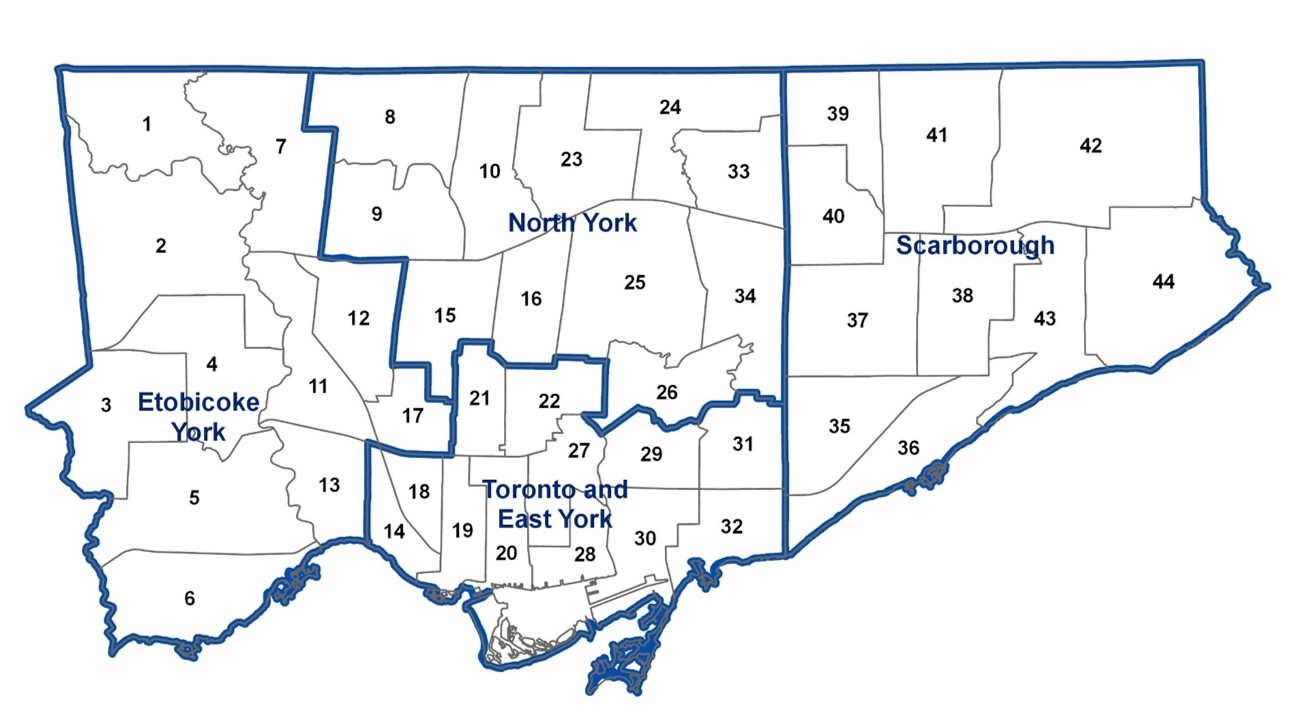

In [8]:
from IPython.display import Image

Image(filename='toronto_districts.jpg')

In [9]:
#check the unique values of column DISTRICT
unique_districts = master_gdf['DISTRICT'].unique()
unique_districts

array(['Toronto and East York', 'Scarborough', 'Etobicoke York',
       'North York', 'None', 'Toronto East York'], dtype=object)

In [10]:
# Merge 'Toronto and East York' and 'Toronto East York' into a single category
master_gdf['DISTRICT'].replace({'Toronto East York': 'Toronto and East York'}, inplace=True)

#rename None to Unspecified
master_gdf['DISTRICT'].replace({'None': 'Unspecified'}, inplace=True)

In [11]:
#check the unique values of column ACCLASS (accident classification)
unique_acclass = master_gdf['ACCLASS'].unique()
unique_acclass

array(['Non-Fatal Injury', 'Fatal', 'Property Damage Only', 'None'],
      dtype=object)

## 1.1 Compare ACCLASS types across Districts

In [12]:
# Group the filtered data by 'DISTRICT' and 'ACCLASS', and calculate counts
grouped_data_initial = master_gdf.groupby(['DISTRICT', 'ACCLASS']).size().reset_index(name='Count')

In [13]:
# Pivot the grouped data to get a table view
table_view = grouped_data_initial.pivot(index='DISTRICT', columns='ACCLASS', values='Count').fillna(0)

# Convert values to integers and move 'None' column to the end
table_view = table_view.astype(int)
table_view = table_view[[col for col in table_view.columns if col != 'None'] + ['None']]

# Calculate the 'TOTAL' column which sums up ACCLASS values per DISTRICT
table_view['TOTAL'] = table_view.sum(axis=1)

# Calculate the 'Fatal to Non-Fatal Injury ratio' column
table_view['Fatal_to_NonFatal_Ratio'] = table_view['Fatal'] / table_view['Non-Fatal Injury']

# Style the table highlighting only the highest value per column
def highlight_max(s):
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

styled_table = table_view.style.apply(highlight_max)

# Set the caption for the table
styled_table.set_caption('Accident Counts by District and Classification')

# Display the styled table with the highest value per column highlighted
styled_table

ACCLASS,Fatal,Non-Fatal Injury,Property Damage Only,None,TOTAL,Fatal_to_NonFatal_Ratio
DISTRICT,,,,,,
Etobicoke York,294,1710,2,0,2006,0.171930
North York,266,1328,0,0,1594,0.200301
Scarborough,373,1435,0,5,1813,0.259930
Toronto and East York,273,2456,2,0,2731,0.111156
Unspecified,11,59,3,0,73,0.186441


Since this dataset includes all traffic collisions events where a person was either Killed or Seriously Injured (KSI), it's possible that the cases with "Property Damage Only" and "None" aren't properly represented. Since they are also relatively insignificant in this dataset, we will drop them from our visualization

In [14]:
# Drop rows with 'None' and 'Property Damage Only' values in 'ACCLASS' column
filtered_data = master_gdf[~master_gdf['ACCLASS'].isin(['None', 'Property Damage Only'])]

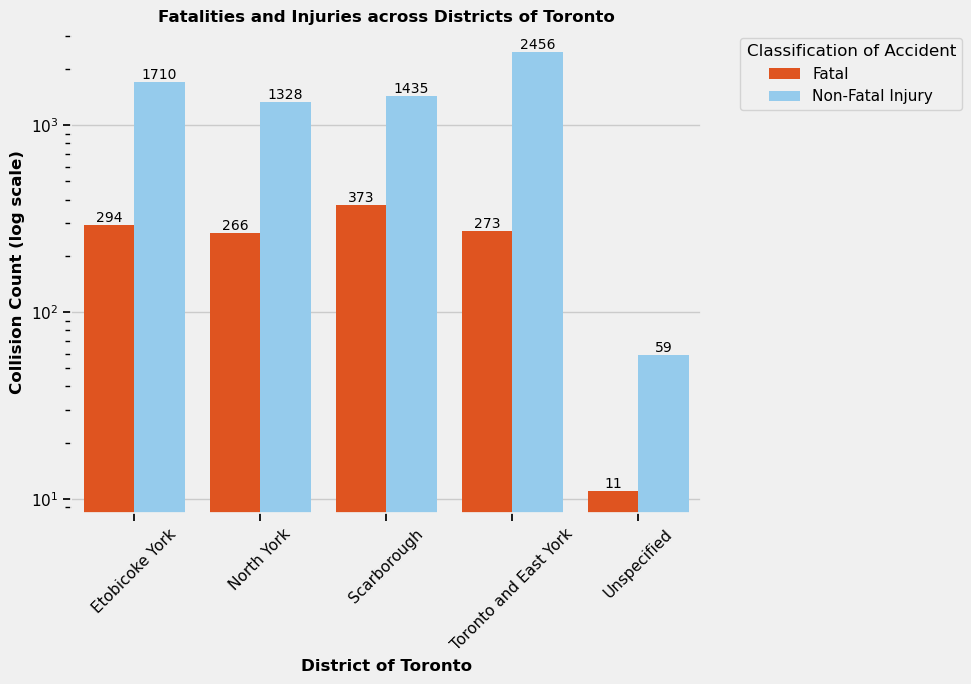

In [15]:
# Group the filtered data by 'DISTRICT' and 'ACCLASS', and calculate counts
grouped_data = filtered_data.groupby(['DISTRICT', 'ACCLASS']).size().reset_index(name='Count')

custom_palette = {'Fatal': 'orangered', 'Non-Fatal Injury': 'lightskyblue'}

# Plotting a grouped bar plot with annotations
plt.figure(figsize=(10, 7))
sns.barplot(x='DISTRICT', y='Count', hue='ACCLASS', data=grouped_data, palette=custom_palette)

# Replace NaN values in 'Count' column with zeros
grouped_data['Count'].fillna(0, inplace=True)

# Annotate the bars with count numbers
for p in plt.gca().patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    if not pd.isnull(y):
        plt.text(x, y, f'{int(y)}', ha='center', va='bottom', fontsize=10)  # Adjust the fontsize as desired

# Set logarithmic scale for y-axis
plt.yscale('log')

# Place the legend outside the plot area
plt.legend(title='Classification of Accident', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Fatalities and Injuries across Districts of Toronto', fontweight='bold')
plt.xlabel('District of Toronto', fontweight='bold')
plt.ylabel('Collision Count (log scale)', fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Exploring Collisions Per Ward

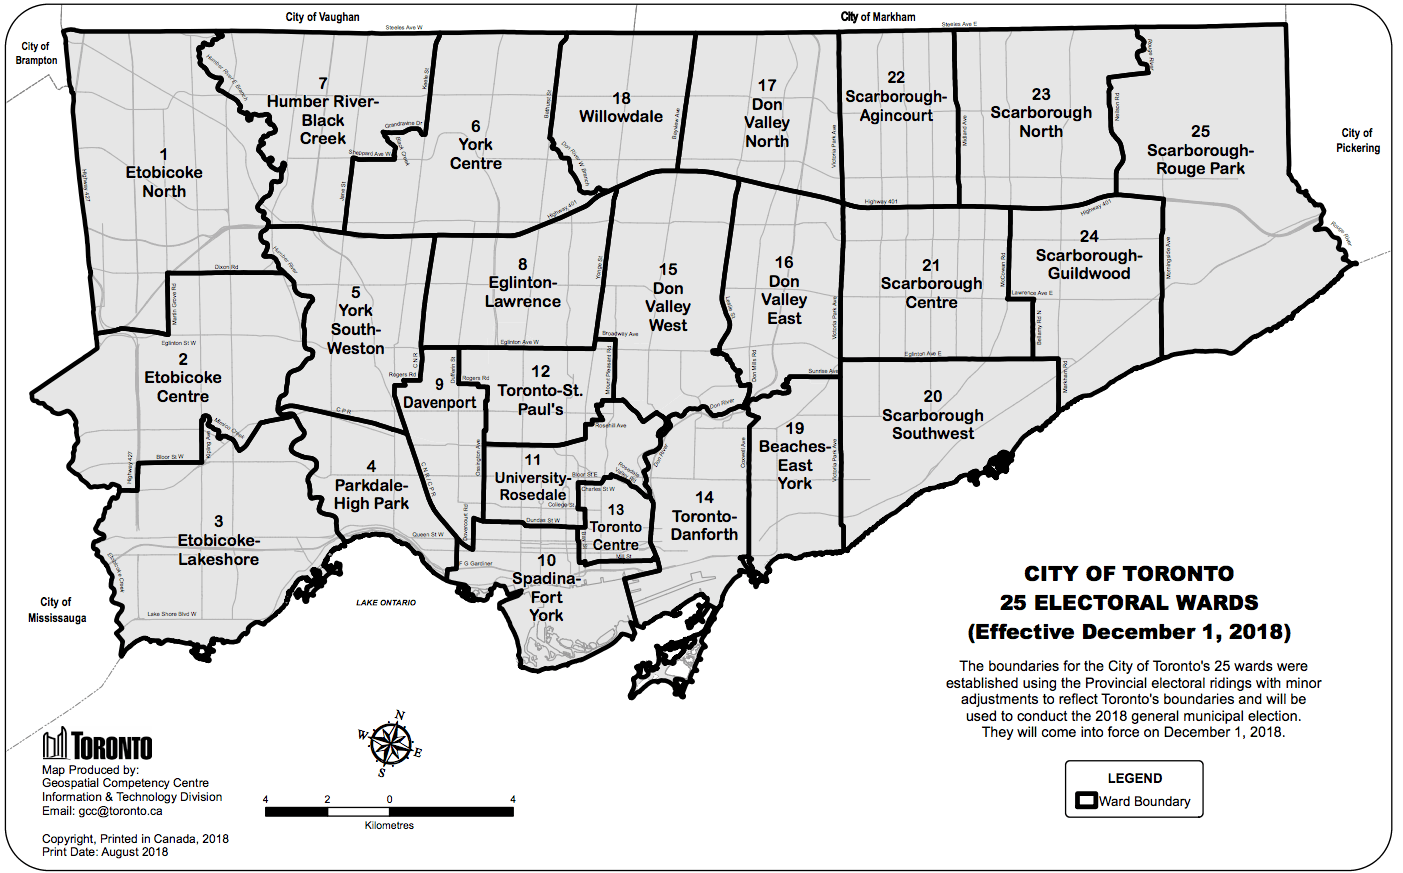

In [16]:
Image(filename='toronto_wards_25.png')

In [17]:
# Filter out rows where 'WARDNUM' is 0 from master_gdf as they are unspecified
filtered_master_gdf = master_gdf[master_gdf['WARDNUM'] != 0]

# Group the filtered data by 'WARDNUM' and calculate counts
ward_collisions = filtered_master_gdf['WARDNUM'].value_counts().reset_index()
ward_collisions.columns = ['WARDNUM', 'Collision_Count']
ward_collisions['WARDNUM'] = ward_collisions['WARDNUM'].astype(str)  # Convert WARDNUM to string

# Sort the wards by collision count in descending order
ward_collisions = ward_collisions.sort_values(by='Collision_Count', ascending=False)

# Select wards with the most collisions (top 10)
top_wards = ward_collisions.head(10)  # Display the top 10 wards

# Remove the decimal from 'WARDNUM'
top_wards['WARDNUM'] = top_wards['WARDNUM'].astype(float).astype(int).astype(str)

# Display the DataFrame with wards having the most collisions
top_wards

,WARDNUM,Collision_Count
0,10,518
1,3,447
2,1,397
3,9,356
4,11,331
5,5,325
6,6,323
7,13,291
8,4,285
9,14,283


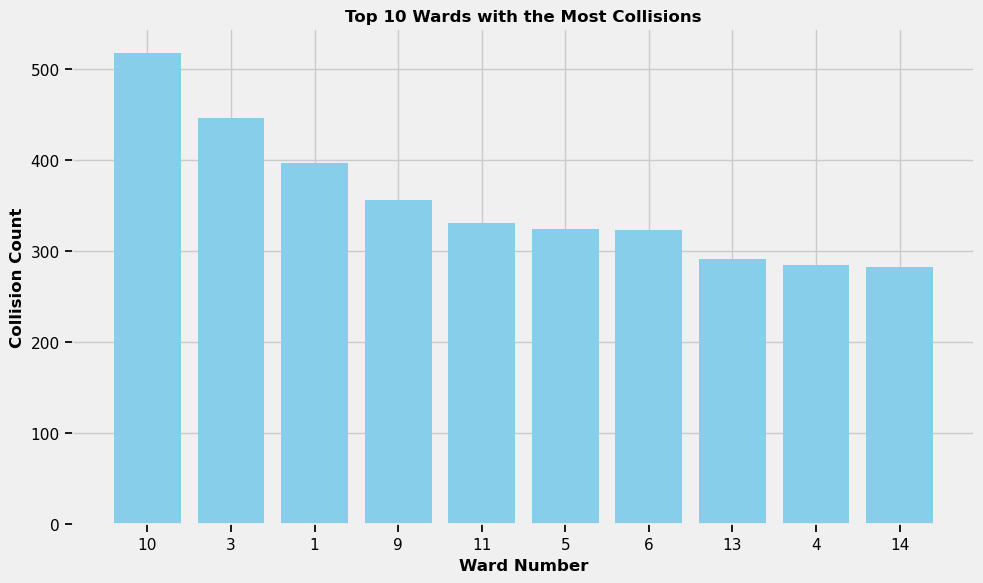

In [18]:
# Plotting a bar graph for the top wards with the most collisions
plt.figure(figsize=(10, 6))
plt.bar(top_wards['WARDNUM'], top_wards['Collision_Count'], color='skyblue')
plt.xlabel('Ward Number', fontweight='bold')
plt.ylabel('Collision Count', fontweight='bold')
plt.title('Top 10 Wards with the Most Collisions', fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Exploring Collisions Per Neighbourhood

In [19]:
# Group the data by 'NEIGHBOURHOOD_158' and calculate counts
neighborhood_collisions = master_gdf['NEIGHBOURHOOD_158'].value_counts().reset_index()
neighborhood_collisions.columns = ['NEIGHBOURHOOD_158', 'Collision_Count']

# Sort the neighborhoods by collision count in descending order
neighborhood_collisions = neighborhood_collisions.sort_values(by='Collision_Count', ascending=False)

# Select neighborhoods with the most collisions (top 10, for example)
top_neighborhoods = neighborhood_collisions.head(10)

# Display the DataFrame with neighborhoods having the most collisions
top_neighborhoods

,NEIGHBOURHOOD_158,Collision_Count
0,West Humber-Clairville,245
1,Yonge-Bay Corridor,200
2,St Lawrence-East Bayfront-The Islands,157
3,South Riverdale,147
4,Wexford/Maryvale,138
5,Moss Park,130
6,Clairlea-Birchmount,128
7,Milliken,127
8,Morningside Heights,126
9,South Parkdale,118


In [20]:
# Group the data by 'NEIGHBOURHOOD_158' and 'ACCLASS' and calculate counts
neighborhood_acclass_collisions = master_gdf.groupby(['NEIGHBOURHOOD_158', 'ACCLASS']).size().reset_index(name='Collision_Count')

# Pivot the table to have ACCLASS as columns
neighborhood_acclass_collisions_pivot = neighborhood_acclass_collisions.pivot(
    index='NEIGHBOURHOOD_158', columns='ACCLASS', values='Collision_Count').fillna(0).astype(int).reset_index()

# Sum up all types of collisions per neighborhood
neighborhood_acclass_collisions_pivot['Total_Collisions'] = neighborhood_acclass_collisions_pivot.sum(axis=1)

# Display the DataFrame with neighborhoods having the most collisions and ACCLASS breakdown
top_neighborhoods = neighborhood_acclass_collisions_pivot.sort_values(by='Total_Collisions', ascending=False).head(10)

#reset the index
top_neighborhoods.reset_index(drop=True, inplace=True)

top_neighborhoods

ACCLASS,NEIGHBOURHOOD_158,Fatal,Non-Fatal Injury,None,Property Damage Only,Total_Collisions
0,West Humber-Clairville,53,192,0,0,245
1,Yonge-Bay Corridor,22,178,0,0,200
2,St Lawrence-East Bayfront-The Islands,31,126,0,0,157
3,South Riverdale,10,137,0,0,147
4,Wexford/Maryvale,25,113,0,0,138
5,Moss Park,19,111,0,0,130
6,Clairlea-Birchmount,28,97,3,0,128
7,Milliken,32,95,0,0,127
8,Morningside Heights,20,106,0,0,126
9,South Parkdale,27,91,0,0,118


In [21]:
# Identify the top 10 neighborhoods
top_neighborhoods_list = [
    "West Humber-Clairville",
    "Yonge-Bay Corridor",
    "St Lawrence-East Bayfront-The Islands",
    "South Riverdale",
    "Wexford/Maryvale",
    "Moss Park",
    "Clairlea-Birchmount",
    "Milliken",
    "Morningside Heights",
    "South Parkdale"
]

# Filter 'master_gdf' for the top 10 neighborhoods
filtered_neighborhoods = master_gdf[master_gdf['NEIGHBOURHOOD_158'].isin(top_neighborhoods_list)]

# Group by 'NEIGHBOURHOOD_158' and get the first geometry for each neighborhood
grouped_neighborhoods = filtered_neighborhoods.groupby('NEIGHBOURHOOD_158')['count_geometry'].first().reset_index()

# Display the DataFrame
grouped_neighborhoods

,NEIGHBOURHOOD_158,count_geometry
0,Clairlea-Birchmount,POINT (-79.2599200047093 43.7168460027539)
1,Milliken,POINT (-79.2804015289569 43.8298427386339)
2,Morningside Heights,POINT (-79.2430980042597 43.82588099868379)
3,Moss Park,POINT (-79.3670506171421 43.6515475861724)
4,South Parkdale,POINT (-79.43478156145929 43.6339522598184)
5,South Riverdale,POINT (-79.34009200036077 43.66106100253616)
6,St Lawrence-East Bayfront-The Islands,POINT (-79.356095 43.649125)
7,West Humber-Clairville,POINT (-79.60544800143799 43.73912599952)
8,Wexford/Maryvale,POINT (-79.3097937613677 43.742144041446295)
9,Yonge-Bay Corridor,POINT (-79.38662800465791 43.650851999225296)


In [22]:
#Merge the two dataframes together to create a visualization
top_neighborhoods_geometry = pd.merge(top_neighborhoods, grouped_neighborhoods, on='NEIGHBOURHOOD_158', how='right')
top_neighborhoods_geometry = top_neighborhoods_geometry.sort_values(by='Total_Collisions', ascending=False)

top_neighborhoods_geometry

,NEIGHBOURHOOD_158,Fatal,Non-Fatal Injury,None,Property Damage Only,Total_Collisions,count_geometry
7,West Humber-Clairville,53,192,0,0,245,POINT (-79.60544800143799 43.73912599952)
9,Yonge-Bay Corridor,22,178,0,0,200,POINT (-79.38662800465791 43.650851999225296)
6,St Lawrence-East Bayfront-The Islands,31,126,0,0,157,POINT (-79.356095 43.649125)
5,South Riverdale,10,137,0,0,147,POINT (-79.34009200036077 43.66106100253616)
8,Wexford/Maryvale,25,113,0,0,138,POINT (-79.3097937613677 43.742144041446295)
3,Moss Park,19,111,0,0,130,POINT (-79.3670506171421 43.6515475861724)
0,Clairlea-Birchmount,28,97,3,0,128,POINT (-79.2599200047093 43.7168460027539)
1,Milliken,32,95,0,0,127,POINT (-79.2804015289569 43.8298427386339)
2,Morningside Heights,20,106,0,0,126,POINT (-79.2430980042597 43.82588099868379)
4,South Parkdale,27,91,0,0,118,POINT (-79.43478156145929 43.6339522598184)


In [23]:
# Initialize the map centered around Toronto
map_toronto = folium.Map(location=[43.65107, -79.347015], zoom_start=11)

# Sort the GeoDataFrame by Total_Collisions and select the top 3
top_3_locations = top_neighborhoods_geometry.sort_values(by='Total_Collisions', ascending=False).head(3)

# Iterate through each row in the GeoDataFrame to add markers to the map
for idx, row in top_neighborhoods_geometry.iterrows():
    total_collisions = row['Total_Collisions']
    
    # Extracting the latitude and longitude from the geometry
    lat = row['count_geometry'].y
    lon = row['count_geometry'].x
    
    # Create a Marker for each neighborhood
    if row['NEIGHBOURHOOD_158'] in top_3_locations['NEIGHBOURHOOD_158'].values:
        folium.Marker(
            location=[lat, lon],
            popup=f'Total Collisions: {total_collisions}',
            icon=folium.Icon(color='red', icon='glyphicon glyphicon-warning-sign')
        ).add_to(map_toronto)
    else:
        folium.Marker(
            location=[lat, lon],
            popup=f'Total Collisions: {total_collisions}'
        ).add_to(map_toronto)

# Display the map with individual markers as pins
map_toronto

# 4. Exploring Collisions Per Intersections

In [24]:
# Group by count_location and get collisions per intersection
collisions_intersection = master_gdf['count_location'].value_counts().reset_index()
collisions_intersection.columns = ['count_location', 'Collision_Count']
collisions_intersection = collisions_intersection.head(10)

# Merge 'count_geometry' to 'collisions_intersection'
collisions_intersection = collisions_intersection.merge(master_gdf[['count_location', 'count_geometry']].drop_duplicates(subset='count_location', keep='first'), on='count_location', how='left')
collisions_intersection

,count_location,Collision_Count,count_geometry
0,LAKE SHORE BLVD AT LOWER JARVIS ST (PX 210),33,POINT (-79.3698550005375 43.64563100390511)
1,KEELE ST AT SHEPPARD AVE W,27,POINT (-79.4864524292146 43.7447775175544)
2,DON RDWY AT LAKE SHORE BLVD (PX 208),23,POINT (-79.3469619945682 43.65089300184629)
3,HIGHWAY 27 AT STEELES AVE W,23,POINT (-79.6140640965393 43.7554767451202)
4,BATHURST ST AT LAKE SHORE BLVD W (PX 216),23,POINT (-79.39964900154351 43.63648400358271)
5,BAY ST AT LAKE SHORE BLVD W (PX 212),22,POINT (-79.3778230005045 43.6430059966817)
6,LAWRENCE AVE E AT RAILSIDE RD W & UNDERHILL DR,22,POINT (-79.3247058915566 43.7407903739965)
7,BROOKMERE RD AT KIPLING AVE & WESTHUMBER BLVD ...,22,POINT (-79.5746600007904 43.7281389986547)
8,EVANS AVE AT ISLINGTON AVE (PX 775),21,POINT (-79.5113279944798 43.6183930020764)
9,FINCH AVE AT ISLINGTON AVE (PX 947),21,POINT (-79.5686209941994 43.74624699905439)


In [25]:
# Initialize the map centered around Toronto
map_toronto = folium.Map(location=[43.65107, -79.347015], zoom_start=11)

# Sort the intersections by Collision_Count in descending order
top_intersections = collisions_intersection.sort_values(by='Collision_Count', ascending=False).head(3)

# Iterate through each row in the DataFrame to add markers to the map
for idx, row in collisions_intersection.iterrows():
    count_location = row['count_location']
    total_collisions = row['Collision_Count']
    count_geometry = row['count_geometry']
    
    # Extracting the latitude and longitude from the geometry
    lat = count_geometry.y
    lon = count_geometry.x
    
    # Create a Marker for each intersection
    if count_location in top_intersections['count_location'].values:
        # For top 3 intersections, use red pin markers
        folium.Marker(
            location=[lat, lon],
            popup=f'Intersection: {count_location}<br>Total Collisions: {total_collisions}',
            icon=folium.Icon(color='red', icon='glyphicon glyphicon-warning-sign')
        ).add_to(map_toronto)
    else:
        # For other intersections, use default blue markers
        folium.Marker(
            location=[lat, lon],
            popup=f'Intersection: {count_location}<br>Total Collisions: {total_collisions}',
            icon=folium.Icon(color='blue', icon='glyphicon glyphicon-minus-sign')
        ).add_to(map_toronto)

# Display the map with markers for intersections
map_toronto

## Analyzing the total & average daily and hourly traffic on collision

In [26]:
#create daily and average total traffic columns per row
daily_traffic = [
    'daily_sb_cars_r', 'daily_sb_cars_t', 'daily_sb_cars_l', 
    'daily_nb_cars_r', 'daily_nb_cars_t', 'daily_nb_cars_l', 
    'daily_wb_cars_r', 'daily_wb_cars_t', 'daily_wb_cars_l', 
    'daily_eb_cars_r', 'daily_eb_cars_t', 'daily_eb_cars_l', 
    'daily_sb_truck_r', 'daily_sb_truck_t', 'daily_sb_truck_l', 
    'daily_nb_truck_r', 'daily_nb_truck_t', 'daily_nb_truck_l', 
    'daily_wb_truck_r', 'daily_wb_truck_t', 'daily_wb_truck_l', 
    'daily_eb_truck_r', 'daily_eb_truck_t', 'daily_eb_truck_l', 
    'daily_sb_bus_r', 'daily_sb_bus_t', 'daily_sb_bus_l', 
    'daily_nb_bus_r', 'daily_nb_bus_t', 'daily_nb_bus_l', 
    'daily_wb_bus_r', 'daily_wb_bus_t', 'daily_wb_bus_l', 
    'daily_eb_bus_r', 'daily_eb_bus_t', 'daily_eb_bus_l', 
    'daily_nx_peds', 'daily_sx_peds', 'daily_ex_peds', 'daily_wx_peds', 
    'daily_nx_bike', 'daily_sx_bike', 'daily_ex_bike', 'daily_wx_bike', 
    'daily_nx_other', 'daily_sx_other', 'daily_ex_other', 'daily_wx_other'
]

hourly_traffic = [ 'hourly_sb_cars_r', 'hourly_sb_cars_t', 'hourly_sb_cars_l',
    'hourly_nb_cars_r', 'hourly_nb_cars_t', 'hourly_nb_cars_l',
    'hourly_wb_cars_r', 'hourly_wb_cars_t', 'hourly_wb_cars_l',
    'hourly_eb_cars_r', 'hourly_eb_cars_t', 'hourly_eb_cars_l',
    'hourly_sb_truck_r', 'hourly_sb_truck_t', 'hourly_sb_truck_l',
    'hourly_nb_truck_r', 'hourly_nb_truck_t', 'hourly_nb_truck_l',
    'hourly_wb_truck_r', 'hourly_wb_truck_t', 'hourly_wb_truck_l',
    'hourly_eb_truck_r', 'hourly_eb_truck_t', 'hourly_eb_truck_l',
    'hourly_sb_bus_r', 'hourly_sb_bus_t', 'hourly_sb_bus_l',
    'hourly_nb_bus_r', 'hourly_nb_bus_t', 'hourly_nb_bus_l',
    'hourly_wb_bus_r', 'hourly_wb_bus_t', 'hourly_wb_bus_l',
    'hourly_eb_bus_r', 'hourly_eb_bus_t', 'hourly_eb_bus_l',
    'hourly_nx_peds', 'hourly_sx_peds', 'hourly_ex_peds', 'hourly_wx_peds',
    'hourly_nx_bike', 'hourly_sx_bike', 'hourly_ex_bike', 'hourly_wx_bike',
    'hourly_nx_other', 'hourly_sx_other', 'hourly_ex_other', 'hourly_wx_other'
]

#make a new dataframe to prevent overwriting
master_gdf_totals = master_gdf

# Sum the columns along axis=1 to get the total for each row
master_gdf_totals['total_daily_traffic'] = master_gdf[daily_traffic].sum(axis=1)
master_gdf_totals['total_hourly_traffic'] = master_gdf[hourly_traffic].sum(axis=1)

master_gdf_totals

,ACCNUM,YEAR,DATE,TIME,collision_datetime,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,hourly_nx_bike,hourly_sx_bike,hourly_ex_bike,hourly_wx_bike,hourly_nx_other,hourly_sx_other,hourly_ex_other,hourly_wx_other,total_daily_traffic,total_hourly_traffic
0,1237939,2011.0,2011-03-09,726,2011-03-09 07:26:00,COLLEGE Stre,BATHURST Stre,None,Major Arterial,Toronto and East York,...,50.0,2.0,43.0,312.0,0.0,0.0,0.0,0.0,31134.0,4803.0
1,1232522,2011.0,2011-03-09,1145,2011-03-09 11:45:00,JANE ST,ST JOHNS RD,None,Major Arterial,Toronto and East York,...,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,12358.0,2413.0
2,1232522,2011.0,2011-03-09,1145,2011-03-09 11:45:00,JANE ST,ST JOHNS RD,None,Major Arterial,Toronto and East York,...,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,12358.0,2413.0
3,1232522,2011.0,2011-03-09,1145,2011-03-09 11:45:00,JANE ST,ST JOHNS RD,None,Major Arterial,Toronto and East York,...,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,12358.0,2413.0
4,1222866,2011.0,2011-03-12,1917,2011-03-12 19:17:00,CHURCH ST,GOULD ST,None,Minor Arterial,Toronto and East York,...,106.0,27.0,31.0,9.0,0.0,0.0,0.0,0.0,15535.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,2002494669,2022.0,2022-12-21,1750,2022-12-21 17:50:00,GLOUCESTER GRV,WINNETT AVE,None,Local,Unspecified,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2729.0,156.0
8213,2002494669,2022.0,2022-12-21,1750,2022-12-21 17:50:00,GLOUCESTER GRV,WINNETT AVE,None,Local,Unspecified,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2729.0,156.0
8214,2002494669,2022.0,2022-12-21,1750,2022-12-21 17:50:00,GLOUCESTER GRV,WINNETT AVE,None,Local,Unspecified,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2729.0,156.0
8215,2002556621,2022.0,2022-12-30,2234,2022-12-30 22:34:00,BLOOR ST W,MONTROSE AVE,76 m West of,Major Arterial,Toronto and East York,...,0.0,12.0,125.0,120.0,0.0,0.0,0.0,0.0,10827.0,835.0


In [27]:
total_traffic_district = master_gdf_totals.groupby('DISTRICT')[['total_daily_traffic', 'total_hourly_traffic']].sum()
total_traffic_district

,total_daily_traffic,total_hourly_traffic
DISTRICT,,
Etobicoke York,36443783.0,4305920.0
North York,35720120.0,4229976.0
Scarborough,33184941.0,3842688.0
Toronto and East York,48991175.0,5777911.0
Unspecified,1160241.0,106235.0


## # Collisions / Average Traffic

In [28]:
# Now get the average traffic per intersection
traffic_averages = master_gdf_totals.groupby('count_location')[['total_daily_traffic', 'total_hourly_traffic']].mean()
traffic_averages.columns = ['average_daily_traffic', 'average_hourly_traffic']

traffic_averages

,average_daily_traffic,average_hourly_traffic
count_location,,
# 1645 SHEPPARD AVE AT DOWNSVIEW DELL PARK / HINCKS DELLCREST CTR,15771.0,1350.000
# 3030 BIRCHMOUNT RD AT BIRCHMOUNT RD (NORTH DRIVEWAY),10784.0,2434.000
# 4400 DUFFERIN ST AT DUFFERIN ST & 250M N STANSTEAD DR (PX 1625),42242.0,915.000
1630 LAWRENCE AVE W AT 55M E OF OLYMPIA DR (PX 1624),18898.0,1535.000
3410 MIDLAND AVE,12834.0,1219.125
...,...,...
YONGE ST AT ORCHARD VIEW BLVD & ROEHAMPTON AVE (PX 2144),18527.0,2913.000
YONGE ST AT SHAFTESBURY AVE,11936.0,1496.000
YONGE ST AT WILSON AVE & YORK MILLS RD,37163.0,6491.000


## Get the daily and hourly collision / volume ratio using the Averages

In [29]:
# Merge two DataFrames, intersections and traffic averages on a common column
collision_to_volume = pd.merge(collisions_intersection, traffic_averages, on='count_location')

collision_to_volume['daily_ratio'] = collision_to_volume['Collision_Count'] / collision_to_volume['average_daily_traffic']
collision_to_volume['hourly_ratio'] = collision_to_volume['Collision_Count'] / collision_to_volume['average_hourly_traffic']

# Display the merged DataFrame
collision_to_volume.head(10)

,count_location,Collision_Count,count_geometry,average_daily_traffic,average_hourly_traffic,daily_ratio,hourly_ratio
0,LAKE SHORE BLVD AT LOWER JARVIS ST (PX 210),33,POINT (-79.3698550005375 43.64563100390511),28095.363636,3358.515152,0.001175,0.009826
1,KEELE ST AT SHEPPARD AVE W,27,POINT (-79.4864524292146 43.7447775175544),26611.666667,3896.666667,0.001015,0.006929
2,DON RDWY AT LAKE SHORE BLVD (PX 208),23,POINT (-79.3469619945682 43.65089300184629),13330.478261,2308.565217,0.001725,0.009963
3,HIGHWAY 27 AT STEELES AVE W,23,POINT (-79.6140640965393 43.7554767451202),26305.869565,2481.826087,0.000874,0.009267
4,BATHURST ST AT LAKE SHORE BLVD W (PX 216),23,POINT (-79.39964900154351 43.63648400358271),26457.478261,3157.217391,0.000869,0.007285
5,BAY ST AT LAKE SHORE BLVD W (PX 212),22,POINT (-79.3778230005045 43.6430059966817),30629.000000,2702.000000,0.000718,0.008142
6,LAWRENCE AVE E AT RAILSIDE RD W & UNDERHILL DR,22,POINT (-79.3247058915566 43.7407903739965),33684.000000,5937.000000,0.000653,0.003706
7,BROOKMERE RD AT KIPLING AVE & WESTHUMBER BLVD ...,22,POINT (-79.5746600007904 43.7281389986547),10932.000000,1306.954545,0.002012,0.016833
8,EVANS AVE AT ISLINGTON AVE (PX 775),21,POINT (-79.5113279944798 43.6183930020764),17877.000000,1393.380952,0.001175,0.015071
9,FINCH AVE AT ISLINGTON AVE (PX 947),21,POINT (-79.5686209941994 43.74624699905439),25436.000000,1845.000000,0.000826,0.011382


In [30]:
# sort in descending order for daily_ratio (averages)
collision_to_volume = collision_to_volume.sort_values(by='daily_ratio', ascending=False).head(10)
collision_to_volume

,count_location,Collision_Count,count_geometry,average_daily_traffic,average_hourly_traffic,daily_ratio,hourly_ratio
7,BROOKMERE RD AT KIPLING AVE & WESTHUMBER BLVD ...,22,POINT (-79.5746600007904 43.7281389986547),10932.000000,1306.954545,0.002012,0.016833
2,DON RDWY AT LAKE SHORE BLVD (PX 208),23,POINT (-79.3469619945682 43.65089300184629),13330.478261,2308.565217,0.001725,0.009963
8,EVANS AVE AT ISLINGTON AVE (PX 775),21,POINT (-79.5113279944798 43.6183930020764),17877.000000,1393.380952,0.001175,0.015071
0,LAKE SHORE BLVD AT LOWER JARVIS ST (PX 210),33,POINT (-79.3698550005375 43.64563100390511),28095.363636,3358.515152,0.001175,0.009826
1,KEELE ST AT SHEPPARD AVE W,27,POINT (-79.4864524292146 43.7447775175544),26611.666667,3896.666667,0.001015,0.006929
3,HIGHWAY 27 AT STEELES AVE W,23,POINT (-79.6140640965393 43.7554767451202),26305.869565,2481.826087,0.000874,0.009267
4,BATHURST ST AT LAKE SHORE BLVD W (PX 216),23,POINT (-79.39964900154351 43.63648400358271),26457.478261,3157.217391,0.000869,0.007285
9,FINCH AVE AT ISLINGTON AVE (PX 947),21,POINT (-79.5686209941994 43.74624699905439),25436.000000,1845.000000,0.000826,0.011382
5,BAY ST AT LAKE SHORE BLVD W (PX 212),22,POINT (-79.3778230005045 43.6430059966817),30629.000000,2702.000000,0.000718,0.008142
6,LAWRENCE AVE E AT RAILSIDE RD W & UNDERHILL DR,22,POINT (-79.3247058915566 43.7407903739965),33684.000000,5937.000000,0.000653,0.003706


These results show that although some intersections have a relatively low collision count, due to their lower average traffic, they have high daily and hourly ratios. These intersections are also important to take into account, as their rate of collisions is notably high, as opposed to intersections with high collisions due to high volumes

# # Collisions / Total Traffic

In [31]:
traffic_sums = master_gdf_totals.groupby('count_location')[['total_daily_traffic', 'total_hourly_traffic']].sum()
traffic_sums

,total_daily_traffic,total_hourly_traffic
count_location,,
# 1645 SHEPPARD AVE AT DOWNSVIEW DELL PARK / HINCKS DELLCREST CTR,31542.0,2700.0
# 3030 BIRCHMOUNT RD AT BIRCHMOUNT RD (NORTH DRIVEWAY),32352.0,7302.0
# 4400 DUFFERIN ST AT DUFFERIN ST & 250M N STANSTEAD DR (PX 1625),126726.0,2745.0
1630 LAWRENCE AVE W AT 55M E OF OLYMPIA DR (PX 1624),37796.0,3070.0
3410 MIDLAND AVE,205344.0,19506.0
...,...,...
YONGE ST AT ORCHARD VIEW BLVD & ROEHAMPTON AVE (PX 2144),111162.0,17478.0
YONGE ST AT SHAFTESBURY AVE,47744.0,5984.0
YONGE ST AT WILSON AVE & YORK MILLS RD,706097.0,123329.0


## Get the daily and hourly collision / volume ratio using the Totals

In [32]:
collision_total_traffic = pd.merge(collisions_intersection, traffic_sums, on='count_location')

collision_total_traffic['daily_ratio'] = collision_total_traffic['Collision_Count'] / collision_total_traffic['total_daily_traffic']
collision_total_traffic['hourly_ratio'] = collision_total_traffic['Collision_Count'] / collision_total_traffic['total_hourly_traffic']

collision_total_traffic

,count_location,Collision_Count,count_geometry,total_daily_traffic,total_hourly_traffic,daily_ratio,hourly_ratio
0,LAKE SHORE BLVD AT LOWER JARVIS ST (PX 210),33,POINT (-79.3698550005375 43.64563100390511),927147.0,110831.0,0.000036,0.000298
1,KEELE ST AT SHEPPARD AVE W,27,POINT (-79.4864524292146 43.7447775175544),718515.0,105210.0,0.000038,0.000257
2,DON RDWY AT LAKE SHORE BLVD (PX 208),23,POINT (-79.3469619945682 43.65089300184629),306601.0,53097.0,0.000075,0.000433
3,HIGHWAY 27 AT STEELES AVE W,23,POINT (-79.6140640965393 43.7554767451202),605035.0,57082.0,0.000038,0.000403
4,BATHURST ST AT LAKE SHORE BLVD W (PX 216),23,POINT (-79.39964900154351 43.63648400358271),608522.0,72616.0,0.000038,0.000317
5,BAY ST AT LAKE SHORE BLVD W (PX 212),22,POINT (-79.3778230005045 43.6430059966817),673838.0,59444.0,0.000033,0.000370
6,LAWRENCE AVE E AT RAILSIDE RD W & UNDERHILL DR,22,POINT (-79.3247058915566 43.7407903739965),741048.0,130614.0,0.000030,0.000168
7,BROOKMERE RD AT KIPLING AVE & WESTHUMBER BLVD ...,22,POINT (-79.5746600007904 43.7281389986547),240504.0,28753.0,0.000091,0.000765
8,EVANS AVE AT ISLINGTON AVE (PX 775),21,POINT (-79.5113279944798 43.6183930020764),375417.0,29261.0,0.000056,0.000718
9,FINCH AVE AT ISLINGTON AVE (PX 947),21,POINT (-79.5686209941994 43.74624699905439),534156.0,38745.0,0.000039,0.000542


In [33]:
# sort in descending order for daily_ratio (totals)
total_collision_to_volume = collision_total_traffic.sort_values(by='daily_ratio', ascending=False).head(10)
total_collision_to_volume

,count_location,Collision_Count,count_geometry,total_daily_traffic,total_hourly_traffic,daily_ratio,hourly_ratio
7,BROOKMERE RD AT KIPLING AVE & WESTHUMBER BLVD ...,22,POINT (-79.5746600007904 43.7281389986547),240504.0,28753.0,0.000091,0.000765
2,DON RDWY AT LAKE SHORE BLVD (PX 208),23,POINT (-79.3469619945682 43.65089300184629),306601.0,53097.0,0.000075,0.000433
8,EVANS AVE AT ISLINGTON AVE (PX 775),21,POINT (-79.5113279944798 43.6183930020764),375417.0,29261.0,0.000056,0.000718
9,FINCH AVE AT ISLINGTON AVE (PX 947),21,POINT (-79.5686209941994 43.74624699905439),534156.0,38745.0,0.000039,0.000542
3,HIGHWAY 27 AT STEELES AVE W,23,POINT (-79.6140640965393 43.7554767451202),605035.0,57082.0,0.000038,0.000403
4,BATHURST ST AT LAKE SHORE BLVD W (PX 216),23,POINT (-79.39964900154351 43.63648400358271),608522.0,72616.0,0.000038,0.000317
1,KEELE ST AT SHEPPARD AVE W,27,POINT (-79.4864524292146 43.7447775175544),718515.0,105210.0,0.000038,0.000257
0,LAKE SHORE BLVD AT LOWER JARVIS ST (PX 210),33,POINT (-79.3698550005375 43.64563100390511),927147.0,110831.0,0.000036,0.000298
5,BAY ST AT LAKE SHORE BLVD W (PX 212),22,POINT (-79.3778230005045 43.6430059966817),673838.0,59444.0,0.000033,0.000370
6,LAWRENCE AVE E AT RAILSIDE RD W & UNDERHILL DR,22,POINT (-79.3247058915566 43.7407903739965),741048.0,130614.0,0.000030,0.000168


We can see that the results when apply average v.s. total traffic volumes are relatively similar.

# 5. Feature Engineering Design

Exploring which spatial features may be useful, the application of this feature engineering function can be found in the ML notebook

In [34]:
# how is R calculated?
intersection_r = pd.read_csv('intersection_r.csv')
intersection_r.head()

,count_location,ROAD_CLASS,TRAFFCTL,num_of_collisions,total_traffic,average_int_width,years,r
0,BATHURST ST AT COLLEGE ST (PX 300),Major Arterial,No Control,18,20083.944444,0.015,11,1.488150
1,JANE ST AT ST JOHNS RD (PX 523),Major Arterial,Traffic Signal,3,11620.000000,0.015,11,0.428685
2,CHURCH ST AT GOULD ST (PX 993),Minor Arterial,Traffic Signal,10,9440.000000,0.015,11,1.758941
3,CHARLES ST E AT CHURCH ST (PX 225),Minor Arterial,No Control,2,11585.000000,0.015,11,0.286653
4,KING ST E AT PRINCESS ST,Major Arterial,No Control,11,5304.000000,0.015,11,3.443597


We can see it takes into account the num_of_collisions, total_trafic, average_int_width, and years. Therefore we cannot use columns those in our feature engineering. As per our analysis, we can see that there are definitely correlations between the location (district, ward, neighbourhood, intersection) and collision likelihood. As such, we will start our feature engineering by implementing ward and neighbourhood characteristics. We will do this by assigning a float to each ward and neighbourhood calculated by dividing the number of collisions there by total collisions. Also take into account which wards and neighbourhoods have more traffic volumes which would impact number of collisions as well

In [35]:
def feature_engineering(data): 

    #ONE: PERCENTAGE OF COLLISIONS IN THIS NEIGHBOURHOOD
    # Calculate the count of occurrences of each neighborhood as a proxy for collisions
    collisions_per_neighborhood = data['NEIGHBOURHOOD_158'].value_counts().reset_index()
    collisions_per_neighborhood.columns = ['NEIGHBOURHOOD_158', 'collisions_count']

    # Calculate total collisions for all neighborhoods
    total_collisions_all = collisions_per_neighborhood['collisions_count'].sum()

    # Compute ratio of collisions per neighborhood to total collisions of all neighborhoods
    collisions_per_neighborhood['collision_ratio_neighbourhood'] = collisions_per_neighborhood['collisions_count'] / total_collisions_all

    # Merge collision ratio information back into master_gdf
    data = data.merge(collisions_per_neighborhood[['NEIGHBOURHOOD_158', 'collision_ratio_neighbourhood']], on='NEIGHBOURHOOD_158', how='left')
    
    
    #TWO: PERCENTAGE OF COLLISIONS IN THIS WARD
    # Calculate the count of occurrences of each neighborhood as a proxy for collisions
    collisions_per_ward = data['WARDNUM'].value_counts().reset_index()
    collisions_per_ward.columns = ['WARDNUM', 'collisions_count']

    # Calculate total collisions for all wards
    total_collisions_wards = collisions_per_ward['collisions_count'].sum()

    # Compute ratio of collisions per ward to total collisions of all wards
    collisions_per_ward['collision_ratio_ward'] = collisions_per_ward['collisions_count'] / total_collisions_wards

    # Merge collision ratio information back into master_gdf
    data = data.merge(collisions_per_ward[['WARDNUM', 'collision_ratio_ward']], on='WARDNUM', how='left')
    
    
    #THREE: Use traffic volumes as the differentiator between neighbourhoods
    daily_traffic = [
    'daily_sb_cars_r', 'daily_sb_cars_t', 'daily_sb_cars_l', 
    'daily_nb_cars_r', 'daily_nb_cars_t', 'daily_nb_cars_l', 
    'daily_wb_cars_r', 'daily_wb_cars_t', 'daily_wb_cars_l', 
    'daily_eb_cars_r', 'daily_eb_cars_t', 'daily_eb_cars_l', 
    'daily_sb_truck_r', 'daily_sb_truck_t', 'daily_sb_truck_l', 
    'daily_nb_truck_r', 'daily_nb_truck_t', 'daily_nb_truck_l', 
    'daily_wb_truck_r', 'daily_wb_truck_t', 'daily_wb_truck_l', 
    'daily_eb_truck_r', 'daily_eb_truck_t', 'daily_eb_truck_l', 
    'daily_sb_bus_r', 'daily_sb_bus_t', 'daily_sb_bus_l', 
    'daily_nb_bus_r', 'daily_nb_bus_t', 'daily_nb_bus_l', 
    'daily_wb_bus_r', 'daily_wb_bus_t', 'daily_wb_bus_l', 
    'daily_eb_bus_r', 'daily_eb_bus_t', 'daily_eb_bus_l', 
    'daily_nx_peds', 'daily_sx_peds', 'daily_ex_peds', 'daily_wx_peds', 
    'daily_nx_bike', 'daily_sx_bike', 'daily_ex_bike', 'daily_wx_bike', 
    'daily_nx_other', 'daily_sx_other', 'daily_ex_other', 'daily_wx_other'
    ]

    hourly_traffic = [ 'hourly_sb_cars_r', 'hourly_sb_cars_t', 'hourly_sb_cars_l',
    'hourly_nb_cars_r', 'hourly_nb_cars_t', 'hourly_nb_cars_l',
    'hourly_wb_cars_r', 'hourly_wb_cars_t', 'hourly_wb_cars_l',
    'hourly_eb_cars_r', 'hourly_eb_cars_t', 'hourly_eb_cars_l',
    'hourly_sb_truck_r', 'hourly_sb_truck_t', 'hourly_sb_truck_l',
    'hourly_nb_truck_r', 'hourly_nb_truck_t', 'hourly_nb_truck_l',
    'hourly_wb_truck_r', 'hourly_wb_truck_t', 'hourly_wb_truck_l',
    'hourly_eb_truck_r', 'hourly_eb_truck_t', 'hourly_eb_truck_l',
    'hourly_sb_bus_r', 'hourly_sb_bus_t', 'hourly_sb_bus_l',
    'hourly_nb_bus_r', 'hourly_nb_bus_t', 'hourly_nb_bus_l',
    'hourly_wb_bus_r', 'hourly_wb_bus_t', 'hourly_wb_bus_l',
    'hourly_eb_bus_r', 'hourly_eb_bus_t', 'hourly_eb_bus_l',
    'hourly_nx_peds', 'hourly_sx_peds', 'hourly_ex_peds', 'hourly_wx_peds',
    'hourly_nx_bike', 'hourly_sx_bike', 'hourly_ex_bike', 'hourly_wx_bike',
    'hourly_nx_other', 'hourly_sx_other', 'hourly_ex_other', 'hourly_wx_other'
    ]

    # Sum the columns along axis=1 to get the total for each row
    data['total_daily_traffic'] = data[daily_traffic].sum(axis=1)
    data['total_hourly_traffic'] = data[hourly_traffic].sum(axis=1)
    
    #groupby neighbourhood and get the average traffic for each neighbourhood
    average_traffic_per_neighborhood = data.groupby('NEIGHBOURHOOD_158')[['total_daily_traffic', 'total_hourly_traffic']].mean().reset_index()

    # Merge the average_traffic_per_neighborhood DataFrame back into the original data DataFrame
    data = data.merge(average_traffic_per_neighborhood, on='NEIGHBOURHOOD_158', how='left', suffixes=('', '_avg_neighborhood'))
    
    
    #FOUR: Use traffic volumes as the differentiator between wards
    #groupby ward and get the average traffic for each ward
    average_traffic_per_ward = data.groupby('WARDNUM')[['total_daily_traffic', 'total_hourly_traffic']].mean().reset_index()

    # Merge the average_traffic_per_ward DataFrame back into the original data DataFrame
    data = data.merge(average_traffic_per_ward, on='WARDNUM', how='left', suffixes=('', '_avg_ward'))
    
    
    feature_selected = ['collision_ratio_neighbourhood', 'collision_ratio_ward',
                        'total_daily_traffic_avg_neighborhood', 'total_hourly_traffic_avg_neighborhood',
                       'total_daily_traffic_avg_ward', 'total_hourly_traffic_avg_ward'
                       ]
        
    return data[feature_selected]